# EDAN95 - Applied Machine Learning
### LTH Fall 2019

# Lab 3
### David Larsson & Jonas Lundgren

## Collecting a Dataset

Code from https://github.com/pnugues/edan95.

In [1]:
import os
import random
import shutil

In [2]:
# To create the same dataset
random.seed(0)

original_dataset_dir = "flowers-recognition/flowers"
dataset = "flowers-recognition/flowers_split"

train_dir = os.path.join(dataset, 'train')
validation_dir = os.path.join(dataset, 'validation')
test_dir = os.path.join(dataset, 'test')

categories = os.listdir(original_dataset_dir)
categories = [category for category in categories if not category.startswith('.')]
print('Image types:', categories)
data_folders = [os.path.join(original_dataset_dir, category) for category in categories]

pairs = []
for folder, category in zip(data_folders, categories):
    images = os.listdir(folder)
    images = [image for image in images if not image.startswith('.')]
    pairs.extend([(image, category) for image in images])
    
random.shuffle(pairs)
img_nbr = len(pairs)
train_images = pairs[0:int(0.6 * img_nbr)]
val_images = pairs[int(0.6 * img_nbr):int(0.8 * img_nbr)]
test_images = pairs[int(0.8 * img_nbr):]

# print(train_images)
print(len(train_images))
print(len(val_images))
print(len(test_images))


for image, label in train_images:
    src = os.path.join(original_dataset_dir, label, image)
    dst = os.path.join(train_dir, label, image)
    os.makedirs(os.path.dirname(dst), exist_ok=True)
    shutil.copyfile(src, dst)

for image, label in val_images:
    src = os.path.join(original_dataset_dir, label, image)
    dst = os.path.join(validation_dir, label, image)
    os.makedirs(os.path.dirname(dst), exist_ok=True)
    shutil.copyfile(src, dst)

for image, label in test_images:
    src = os.path.join(original_dataset_dir, label, image)
    dst = os.path.join(test_dir, label, image)
    os.makedirs(os.path.dirname(dst), exist_ok=True)
    shutil.copyfile(src, dst)

Image types: ['dandelion', 'daisy', 'tulip', 'rose', 'sunflower']
2595
865
866


## Building a Simple Convolutional Neural Network

In [3]:
import numpy as np
import matplotlib.pyplot as plt
#from PIL import Image
from IPython.display import Image, display
%matplotlib inline  

Chceck some random flowers

dandelion


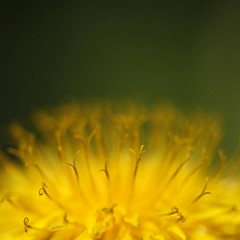

dandelion


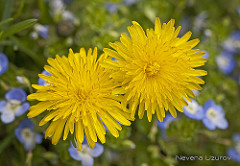

tulip


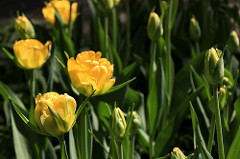

sunflower


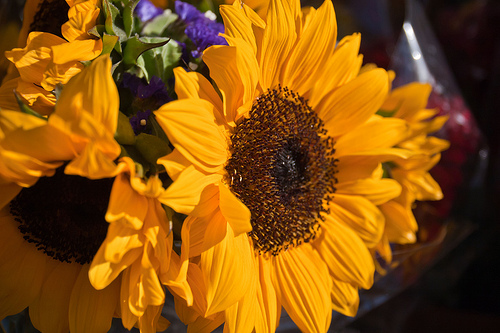

tulip


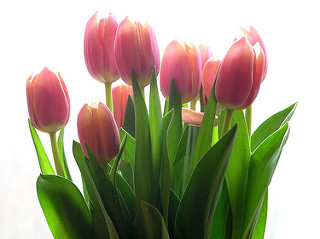

In [4]:
num_flowers = 5
random_flowers_idx = np.random.randint(0, len(train_images), num_flowers)
random_flowers = [train_images[i] for i in random_flowers_idx]

for image, label in random_flowers:
    src = os.path.join(train_dir, label, image)
    print(label)
    display(Image(filename=src))
    #im = Image.open(src)
    #im.show()


In [6]:
from keras import layers
from keras import models
from keras import optimizers
from keras.preprocessing.image import ImageDataGenerator

In [7]:
model = models.Sequential()
model.add(layers.Conv2D(filters = 32, kernel_size = (3, 3), activation = 'relu',
                        input_shape = (150, 150, 3)))
model.add(layers.MaxPool2D(pool_size = (2, 2)))
model.add(layers.Conv2D(filters = 64, kernel_size = (3, 3), activation = 'relu'))
model.add(layers.MaxPool2D(pool_size = (2, 2)))
model.add(layers.Conv2D(filters = 128, kernel_size = (3, 3), activation = 'relu'))
model.add(layers.MaxPool2D(pool_size = (2, 2)))
model.add(layers.Conv2D(filters = 128, kernel_size = (3, 3), activation = 'relu'))
model.add(layers.MaxPool2D(pool_size = (2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(512, activation = 'relu'))
model.add(layers.Dense(5, activation = 'softmax'))

In [8]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 15, 15, 128)      

In [9]:
model.compile(loss = 'categorical_crossentropy',
              optimizer = optimizers.RMSprop(lr = 1e-4),
              metrics = ['acc'])

In [10]:
train_datagen = ImageDataGenerator(rescale = 1. / 255)
val_datagen = ImageDataGenerator(rescale = 1. / 255)
test_datagen = ImageDataGenerator(rescale = 1. / 255)

In [11]:
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    target_size = (150,150),
                                                    batch_size = 20,
                                                    classes = ['dandelion', 'daisy', 'tulip', 'rose', 'sunflower'],
                                                    class_mode = 'categorical')
validation_generator = val_datagen.flow_from_directory(validation_dir,
                                                       target_size = (150,150),
                                                       batch_size = 20,
                                                       classes = ['dandelion', 'daisy', 'tulip', 'rose', 'sunflower'],
                                                       class_mode = 'categorical')
test_generator = test_datagen.flow_from_directory(test_dir,
                                                  target_size = (150,150),
                                                  batch_size = 20,
                                                  classes = ['dandelion', 'daisy', 'tulip', 'rose', 'sunflower'],
                                                  class_mode = 'categorical')

Found 2758 images belonging to 5 classes.
Found 865 images belonging to 5 classes.
Found 865 images belonging to 5 classes.


In [12]:
retrain_model = False
if retrain_model:
    history = model.fit_generator(train_generator,
                                  steps_per_epoch = 100,
                                  epochs = 30, 
                                  validation_data = validation_generator,
                                  validation_steps = 50)

In [13]:
if retrain_model:
    model.save_weights('model_1_lab3.model')
else:
    model.load_weights('model_1_lab3.model')

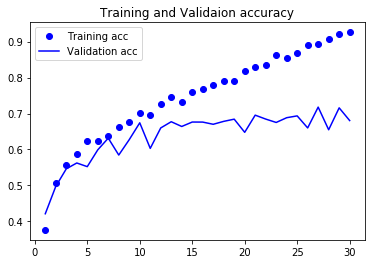

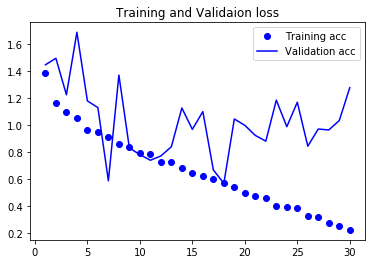

In [14]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label = 'Training acc')
plt.plot(epochs, val_acc, 'b', label = 'Validation acc')
plt.title('Training and Validaion accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label = 'Training acc')
plt.plot(epochs, val_loss, 'b', label = 'Validation acc')
plt.title('Training and Validaion loss')
plt.legend()

plt.show()

In [14]:
y_hat = model.predict_generator(test_generator)
y_pred = np.argmax(y_hat, axis=1)
y = test_generator.classes

In [15]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y, y_pred)

array([[62, 40, 36, 49, 41],
       [40, 34, 22, 41, 25],
       [56, 31, 17, 42, 40],
       [37, 34, 17, 39, 22],
       [31, 33, 20, 31, 25]])